# Import

In [1]:
import os
import numpy as np
import pandas as pd
import copy
import time
import matplotlib.pyplot as plt

import random
import scipy.stats as ss

# Load dataset (CAB10)

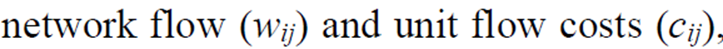

In [2]:
dir_name = os.path.dirname(os.path.realpath('__file__'))

file_name = 'CAB10'
file_path = os.path.join(dir_name,file_name + '.csv')

# Load network flow data
w = pd.read_csv(file_path,nrows=10,header=None)
w.index += 1
w.columns += 1

# Load unit cost data
c = pd.read_csv(file_path,skiprows = 13,nrows=10,header=None)
c.index += 1
c.columns += 1

In [3]:
w

1      2      3      4      5      6      7      8      9      10
1       0   6469   7629  20036   4690   6194  11688   2243   8857   7248
2    6469      0  12999  13692   3322   5576   3878   3202   6699   4198
3    7629  12999      0  35135   5956  14121   5951   5768  16578   4242
4   20036  13692  35135      0  19094  35119  21423  27342  51341  15826
5    4690   3322   5956  19094      0   7284   3102   1562   7180   1917
6    6194   5576  14121  35119   7284      0   5023   3512  10419   3543
7   11688   3878   5951  21423   3102   5023      0  11557   6479  34261
8    2243   3202   5768  27342   1562   3512  11557      0   5615   7095
9    8857   6699  16578  51341   7180  10419   6479   5615      0   4448
10   7248   4198   4242  15826   1917   3543  34261   7095   4448      0

In [4]:
c

1          2          3         4          5          6   \
1      0.0000   576.9631   946.4954  597.5972   373.8127   559.7673   
2    576.9631     0.0000   369.5327  613.0386   429.1079   312.8831   
3    946.4954   369.5327     0.0000  858.3308   749.6018   556.0706   
4    597.5972   613.0386   858.3308    0.0000   255.0303   311.3071   
5    373.8127   429.1079   749.6018  255.0303     0.0000   225.8954   
6    559.7673   312.8831   556.0706  311.3071   225.8954     0.0000   
7    709.0215  1196.4890  1541.2730  790.1213   794.1726  1009.6890   
8   1208.3280  1502.1400  1764.7910  907.4331  1080.3740  1216.8680   
9    603.6477   405.8975   621.3306  237.0703   238.9440    94.2588   
10   695.2080  1241.9610  1603.1650  932.2173   879.5647  1104.5740   

           7          8          9          10  
1    709.0215  1208.3280   603.6477   695.2080  
2   1196.4890  1502.1400   405.8975  1241.9610  
3   1541.2730  1764.7910   621.3306  1603.1650  
4    790.1213   907.4331   237.0703   932.2173  
5    794.1726  1080.3740   238.9440   879.5647  
6   1009.6890  1216.8680    94.2588  1104.5740  
7      0.0000   663.8762   982.7378   221.4220  
8    663.8762     0.0000  1143.7910   874.5181  
9    982.7378  1143.7910     0.0000  1094.9060  
10   221.4220   874.5181  1094.9060     0.0000

## Predefined Functions

In [15]:
def check_feasibility(array, n, p):
        flag = True
        hubs = list(set(array))
        for i in range(n):
            if i+1 in hubs:
                if array[i] == i+1:
                    flag *= True
                else:
                    flag *= False
        return flag

## initial solution

In [7]:
def initial_solution(n, p): 
   
    hubs = random.sample(range(1,n),p)
    array = [None] * n
    for i in range(n):
        if i+1 in hubs:
            array[i] = i+1    
        else:
            array[i] = hubs[random.randint(0,p-1)]
    return array

In [8]:
np.random.seed(5)
# test
initial_solution(10, 3)

[1, 9, 9, 4, 9, 1, 4, 1, 9, 9]

## solution evaluation (cost calculation)

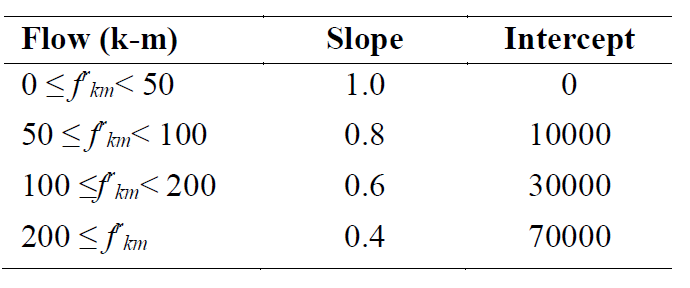

In [9]:
def flowloc_cost_2(flow):
    unit_flow_cost = 0
    
    if flow <0:
        raise ValueError("Flow must be nonnegative")
    elif flow < 50000:
        unit_flow_cost = 0 + 1* flow
    elif flow < 100000:
        unit_flow_cost = 10000 + 0.8* flow
    elif flow < 200000:
        unit_flow_cost = 30000 + 0.6* flow
    else:
        unit_flow_cost = 70000 + 0.4* flow
    return unit_flow_cost


def cost_evaluation(array, w, c):
    total_cost = 0
    
    # identify the hubs
    hubs = set(array)
    
    # calculate collection and distribution cost
    for i in range(1, len(array)+1):
        for j in range(1, len(array)+1):
            total_cost += w[i][j]*(c[i][array[i-1]] + c[array[j-1]][j])
    
    # calculate inter-hub cost
    for k in hubs:
        for m in hubs:
            if k != m:
                interhub_flow = 0
                for i in range(1, len(array)+1):
                    for j in range(1, len(array)+1):
                        if array[i-1] == k and array[j-1] == m:
                            interhub_flow += w[i][j]                   # calculate inter-hub flow
                            
                total_cost += flowloc_cost_2(interhub_flow) * c[k][m]  # calculate inter-hub cost
                
    return total_cost

# GA

## class

In [12]:
iterations = 100

In [29]:
class Ga:
    def __init__(self, n, p):
        self.n = n
        self.p = p
    
       
    def ga(self):
        while True:
            parent_1 = initial_solution(self.n, self.p)
            parent_2 = initial_solution(self.n, self.p)

            cutting_point = random.randint(0, 9)
            offspring = parent_1[:cutting_point] + parent_2[cutting_point:]

            if len(set(offspring)) == self.p and check_feasibility(offspring, self.n, self.p):
                break

        return offspring
    
    def ga_best(self):
        ga_initial = self.ga()
        best_ga = ga_initial
        best_ga_cost = cost_evaluation(ga_initial, w, c)

        i = 1
        while i < iterations:
            next_solution = self.ga()
            ga_cost = cost_evaluation(next_solution, w, c)

            if ga_cost < best_ga_cost:
                best_ga = next_solution
                best_ga_cost= ga_cost

            i += 1

        return best_ga, best_ga_cost

In [17]:
time_start = time.time()  

first_ga = Ga(10, 3)
print(first_ga.ga_best())

time_end = time.time()  
time_sum = time_end - time_start  
print(time_sum)

([4, 5, 5, 4, 5, 4, 7, 4, 4, 4], 910032389.8294402)
0.2520425319671631


## solutions

Hereafter is the solutions for my algorithms, please don't run this part of code due to long computational time.

In [36]:
iterations = 100000

In [37]:
sum_NC = 0
time_start = time.time()  

for i in range(10):
    solution = Ga(10, 3).ga_best()
    print(solution)
    sum_NC += solution[1]

time_end = time.time()  
time_sum = time_end - time_start
print(time_sum)

([4, 9, 9, 4, 4, 9, 7, 4, 9, 7], 740999438.9360801)
([4, 9, 9, 4, 4, 9, 7, 4, 9, 7], 740999438.9360801)
([4, 6, 6, 4, 6, 6, 7, 4, 6, 7], 746458661.9294802)
([4, 9, 9, 4, 4, 9, 7, 4, 9, 7], 740999438.9360801)
([4, 9, 9, 4, 9, 9, 7, 4, 9, 7], 743082616.6257203)
([4, 9, 9, 4, 9, 9, 7, 4, 9, 7], 743082616.6257203)
([9, 9, 9, 4, 9, 9, 7, 4, 9, 7], 750122927.9772803)
([4, 9, 9, 4, 9, 9, 7, 4, 9, 7], 743082616.6257203)
([4, 9, 9, 4, 4, 9, 7, 4, 9, 7], 740999438.9360801)
([4, 9, 9, 4, 9, 9, 7, 4, 9, 7], 743082616.6257203)
2685.232156276703


In [38]:
sum_NC/10

743290981.2153962

# PSO 

## class

In [18]:
SwarmSize = 10

In [25]:
class Pso_Ga:
    def __init__(self, n, p):
        self.n = n
        self.p = p
    
       
    def pso(self):
        first_row = [None] * self.n
        for i in range(self.n):
            first_row[i] = float("%.2f" %(random.random() + random.randint(0 , self.n*self.p)))

        second_row = [None] * self.n
        for i in range(self.n):
            second_row[i] = random.randint(1, self.p)

        array = [None] * self.n
        ranks_first_row = list(ss.rankdata(first_row))
        hubs = [int(i) for i in ranks_first_row][:self.p]  
        allocations = second_row

        for i in range(self.n):
            if i+1 in hubs:
                array[i] = i+1    
            else:
                array[i] = hubs[allocations[i]-1]

        return array, hubs, allocations
    
    
    def cross_over(self):
        particle_1 = self.pso()
        particle_2 = self.pso()

        hubs = particle_1[1]
        allocations = particle_1[2][:round(self.n/2)] + particle_2[2][round(self.n/2):]
        array = [None] * self.n

        
        for i in range(self.n):
            if i+1 in hubs:
                array[i] = i+1    
            else:
                array[i] = hubs[allocations[i] -1]

        return array, hubs, allocations
    
    
    def pso_ga_best(self):        
        pso_ga_initial = self.cross_over()[0]
        best_pso_ga = pso_ga_initial
        best_pso_ga_cost = cost_evaluation(pso_ga_initial, w, c)

        j = 1
        while j < SwarmSize:
            next_solution = self.cross_over()[0]
            pso_ga_cost = cost_evaluation(next_solution, w, c)

            if pso_ga_cost < best_pso_ga_cost:
                best_pso_ga = next_solution
                best_pso_ga_cost= pso_ga_cost

            j += 1

        return best_pso_ga, best_pso_ga_cost

In [27]:
time_start = time.time()  

first_pso_ga = Pso_Ga(10, 3)
print(first_pso_ga.pso_ga_best())

time_end = time.time()  
time_sum = time_end - time_start  
print(time_sum)

([9, 9, 9, 4, 5, 5, 4, 9, 9, 4], 923324103.6052402)
0.031996965408325195


## solutions

Hereafter is the solutions for my algorithms, please don't run this part of code due to long computational time.

In [55]:
SwarmSize = 50000

In [56]:
sum_NC = 0
time_start = time.time()  

for i in range(10):
    solution = Pso_Ga(10, 3).pso_ga_best()
    print(solution)
    sum_NC += solution[1]

time_end = time.time()  
time_sum = time_end - time_start  
print(time_sum)

([4, 9, 9, 4, 4, 9, 7, 4, 9, 7], 740999438.9360801)
([9, 9, 9, 4, 9, 9, 7, 4, 9, 7], 750122927.9772803)
([6, 6, 6, 4, 4, 6, 7, 4, 6, 7], 750795242.3616004)
([9, 9, 9, 4, 9, 9, 7, 4, 9, 7], 750122927.9772803)
([4, 9, 9, 4, 9, 9, 7, 4, 9, 7], 743082616.6257203)
([9, 9, 9, 4, 9, 9, 7, 4, 9, 7], 750122927.9772803)
([4, 9, 9, 4, 4, 9, 7, 4, 9, 7], 740999438.9360801)
([4, 9, 9, 4, 9, 9, 7, 4, 9, 7], 743082616.6257203)
([4, 6, 6, 4, 6, 6, 7, 4, 6, 7], 746458661.9294802)
([4, 9, 9, 4, 9, 9, 7, 4, 9, 7], 743082616.6257203)
1316.9199006557465


In [57]:
sum_NC/10

745886941.5972242